<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/SciKitLearn_05_ProjFive_Supervised_Reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import linalg
from sklearn import metrics
from sklearn import linear_model
from sklearn import preprocessing
import seaborn as sns
import scipy

from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, WhiteKernel, RationalQuadratic, ExpSineSquared

In [ ]:
import sys
import sklearn
print(sys.version)
!python --version
print("numpy: ", np.__version__)
print("sklearn: ", sklearn.__version__)

3.11.4 (main, Jul  5 2023, 08:41:25) [Clang 14.0.6 ]
Python 3.11.4
numpy:  1.23.5
sklearn:  1.2.2


In [ ]:
path = './'
data = pd.read_csv(path + 'co2_mm_mlo.txt', header=0, delimiter='\s+')
data.head(2)

,year,month,decimal,average,de-seasonalized,#days,st.dev,mean
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99


In [ ]:
X = np.array(data['decimal']).reshape(-1,1)
y = np.array(data['average'])

print(X.shape, y.shape)

(785, 1) (785,)


In [ ]:
k1 = 50.0 * RBF(length_scale=50.0)
k2 = 2.0**2 * RBF(length_scale=100.0) *\
        ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds='fixed')
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) +\
        WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-5, np.inf))

kernel = k1 + k2 + k3 + k4

In [ ]:
gp = GaussianProcessRegressor(kernel=kernel, alpha=0, normalize_y=True)
gp.fit(X, y)

print("\nLearned kernel:", gp.kernel_)
print("Log-marginal-likelihood: %.3f" % gp.log_marginal_likelihood(gp.kernel_.theta))


Learned kernel: 2.23**2 * RBF(length_scale=39.9) + 0.0799**2 * RBF(length_scale=134) * ExpSineSquared(length_scale=1.35, periodicity=1) + 0.0298**2 * RationalQuadratic(alpha=0.15, length_scale=1.58) + 0.00637**2 * RBF(length_scale=0.118) + WhiteKernel(noise_level=4.27e-05)
Log-marginal-likelihood: 2488.007


In [ ]:
X_ = np.linspace(X.min(), X.max()+30, 1000)[:, np.newaxis]
print(X_.shape, type(X_))

y_pred, y_std = gp.predict(X_, return_std=True)

(1000, 1) <class 'numpy.ndarray'>


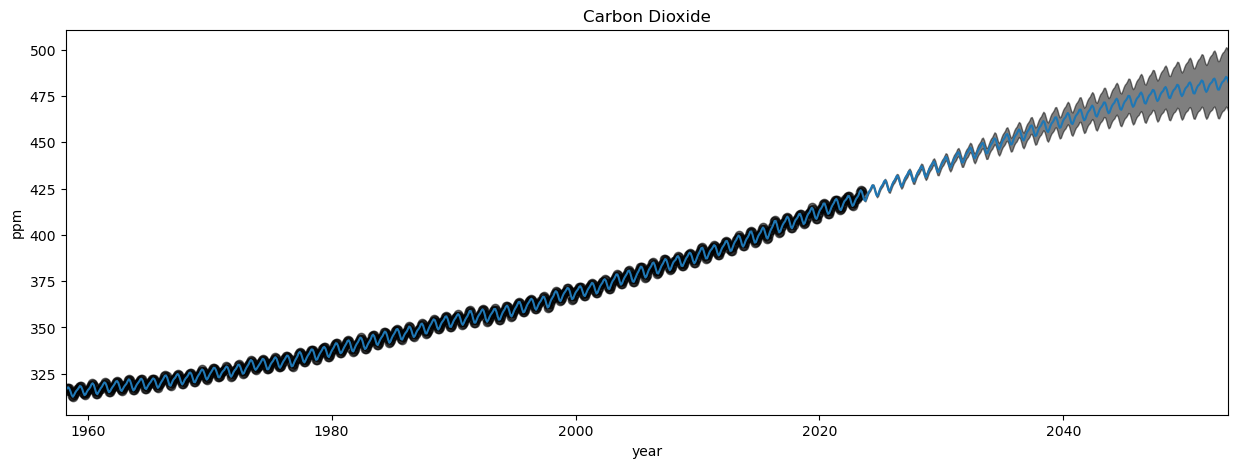

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.scatter(X, y, c='k', alpha=0.55)
plt.plot(X_, y_pred)
plt.fill_between(X_[:,0], y_pred-y_std, y_pred+y_std, alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.xlabel("year")
plt.ylabel("ppm")
plt.title("Carbon Dioxide")
plt.show()

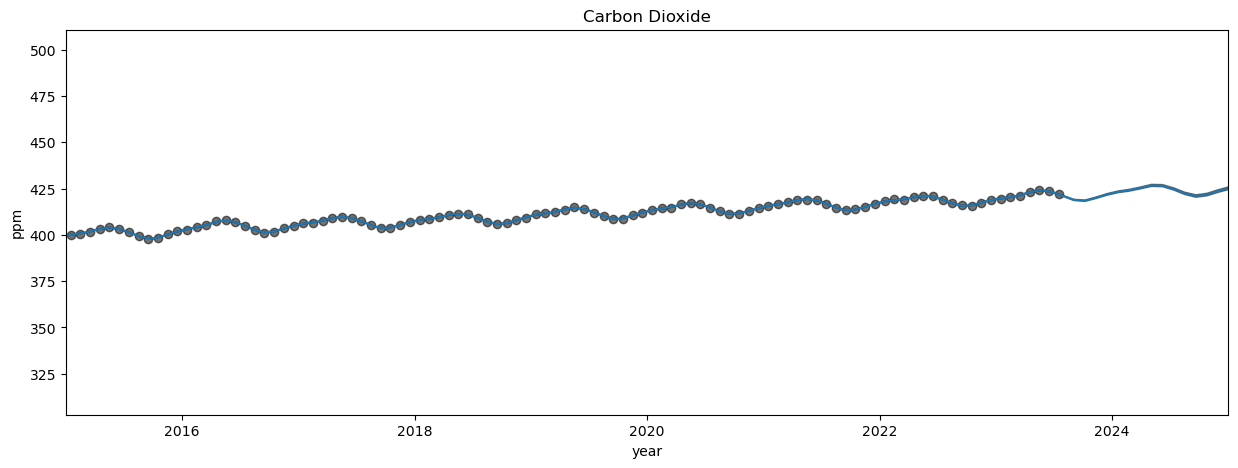

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.scatter(X, y, c='k', alpha=0.55)
plt.plot(X_, y_pred)
plt.fill_between(X_[:,0], y_pred-y_std, y_pred+y_std, alpha=0.5, color='k')
plt.xlim(2015, 2025)
plt.xlabel("year")
plt.ylabel("ppm")
plt.title("Carbon Dioxide")
plt.show()

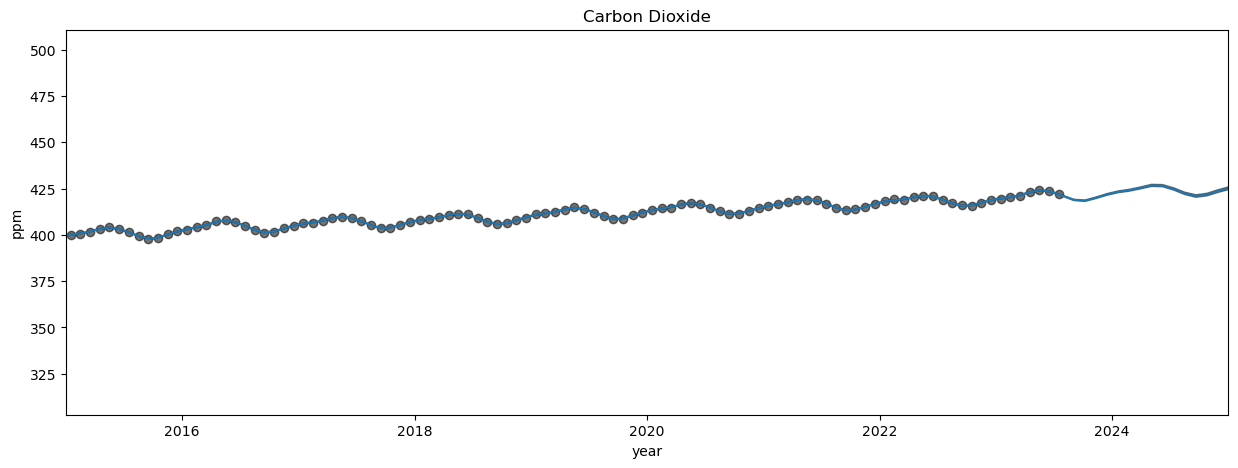

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.scatter(X, y, c='k', alpha=0.55)
plt.plot(X_, y_pred)
plt.fill_between(X_[:,0], y_pred-y_std, y_pred+y_std, alpha=0.5, color='k')
plt.xlim(2015, 2025)
plt.xlabel("year")
plt.ylabel("ppm")
plt.title("Carbon Dioxide")
plt.show()

In [ ]:
data = pd.read_csv(path + 'ch4_mm_gl.txt', header=0, delimiter='\s+')
data.head(2)

,year,month,decimal,average,average_unc,trend,trennd_unc
0,1983,7,1983.542,1626.09,2.10,1635.07,1.39
1,1983,8,1983.625,1628.01,2.69,1635.62,1.33


In [ ]:
X = np.array(data['decimal']).reshape(-1,1)
y = np.array(data['average'])

print(X.shape, y.shape)

(478, 1) (478,)


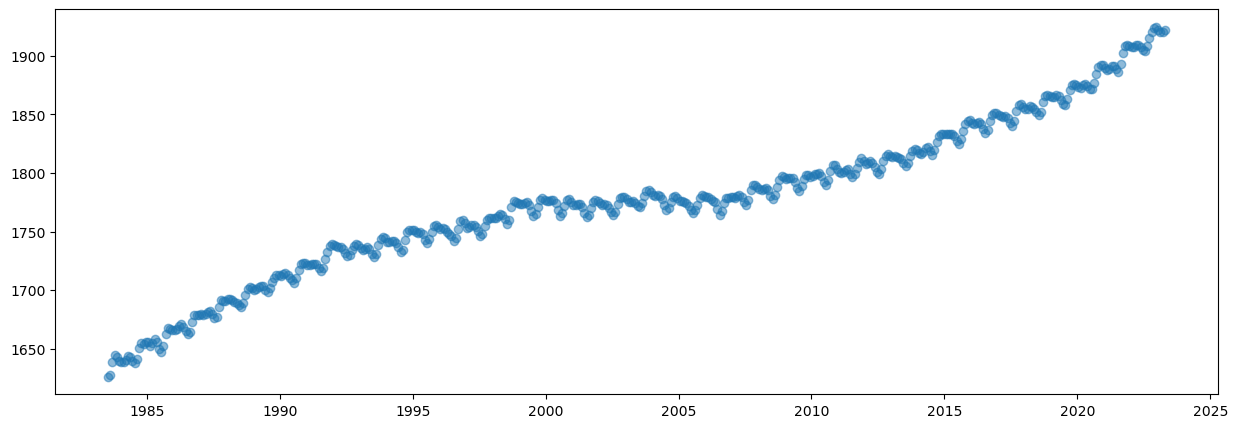

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.scatter(X, y, alpha=0.5)

In [ ]:
k1 = 2.0**2 * RBF(length_scale=100.0) *\
     ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds='fixed')
k2 = 0.1**2 * RBF(length_scale=0.1) +\
     WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5))
k3 = 2.0**2 * RBF(length_scale=1.0) *\
     ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds='fixed')

kernel = k1 + k2 + k3

In [ ]:
gp = GaussianProcessRegressor(kernel=kernel, alpha=0, normalize_y=True, n_restarts_optimizer=3)
gp.fit(X, y)

print("\nLearned kernel:", gp.kernel_)
print("Log-marginal-likelihood: %.3f" % gp.log_marginal_likelihood(gp.kernel_.theta))


Learned kernel: 3.29**2 * RBF(length_scale=101) * ExpSineSquared(length_scale=3.77, periodicity=1) + 0.0255**2 * RBF(length_scale=0.113) + WhiteKernel(noise_level=1e-05) + 0.236**2 * RBF(length_scale=2.03) * ExpSineSquared(length_scale=1.75e+04, periodicity=1)
Log-marginal-likelihood: 1308.234


/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
X_ = np.linspace(X.min(), X.max()+30, 1000)[:, np.newaxis]
print(X_.shape, type(X_))

y_pred, y_std = gp.predict(X_, return_std=True)

(1000, 1) <class 'numpy.ndarray'>


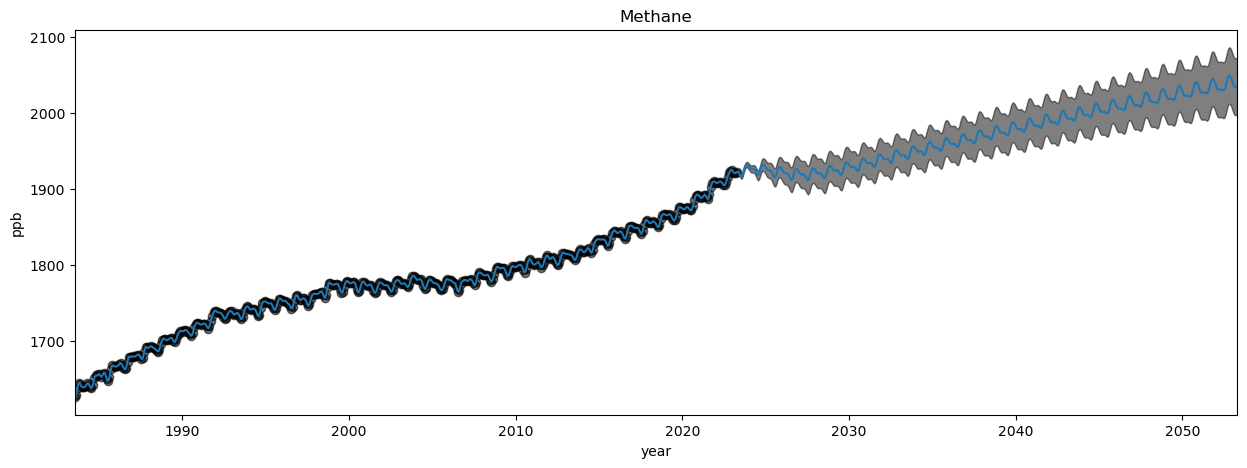

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.scatter(X, y, c='k', alpha=0.55)
plt.plot(X_, y_pred)
plt.fill_between(X_[:,0], y_pred-y_std, y_pred+y_std, alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.xlabel("year")
plt.ylabel("ppb")
plt.title("Methane")
plt.show()

In [ ]:
data = pd.read_csv(path + 'n2o_mm_gl.txt', header=0, delimiter='\s+')
data.head(2)

,year,month,decimal,average,average_unc,trend,trennd_unc
0,2001,1,2001.042,316.30,0.17,316.03,0.16
1,2001,2,2001.125,316.31,0.18,316.09,0.16


In [ ]:
X = np.array(data['decimal']).reshape(-1,1)
y = np.array(data['average'])

print(X.shape, y.shape)

(268, 1) (268,)


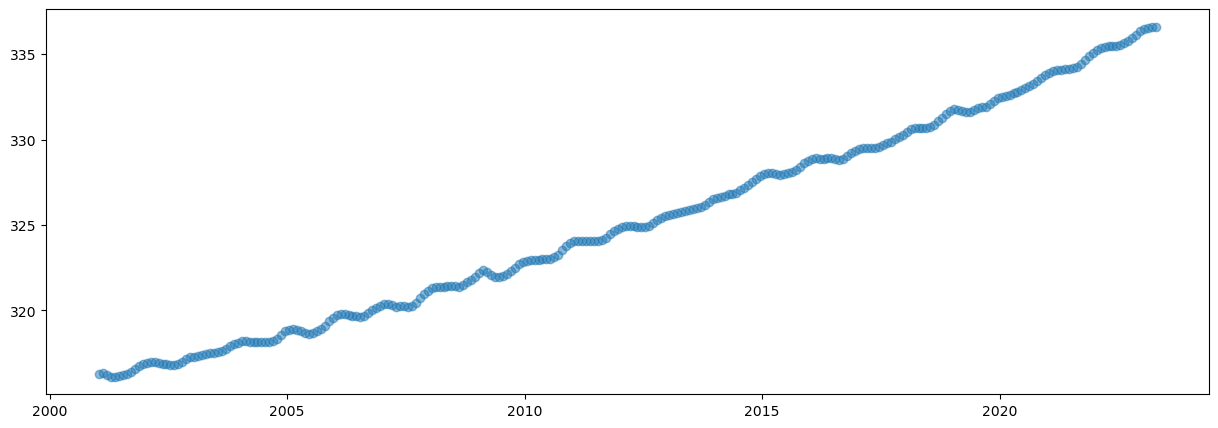

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.scatter(X, y, alpha=0.5)

In [ ]:
k1 = 2.0**2 * RBF(length_scale=100.0) *\
     ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds='fixed')
k2 = 0.1**2 * RBF(length_scale=0.1) +\
     WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5))
k3 = 2.0**2 * RBF(length_scale=100.0) *\
     ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds='fixed')

kernel = k1 + k2 + k3

In [ ]:
gp = GaussianProcessRegressor(kernel=kernel, alpha=0, normalize_y=True, n_restarts_optimizer=3)
gp.fit(X, y)

print("\nLearned kernel:", gp.kernel_)
print("Log-marginal-likelihood: %.3f" % gp.log_marginal_likelihood(gp.kernel_.theta))


Learned kernel: 1.94**2 * RBF(length_scale=12.1) * ExpSineSquared(length_scale=168, periodicity=1) + 0.0192**2 * RBF(length_scale=0.173) + WhiteKernel(noise_level=1e-05) + 1.94**2 * RBF(length_scale=12.1) * ExpSineSquared(length_scale=168, periodicity=1)
Log-marginal-likelihood: 928.352


/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
X_ = np.linspace(X.min(), X.max()+30, 1000)[:, np.newaxis]
print(X_.shape, type(X_))

y_pred, y_std = gp.predict(X_, return_std=True)

(1000, 1) <class 'numpy.ndarray'>


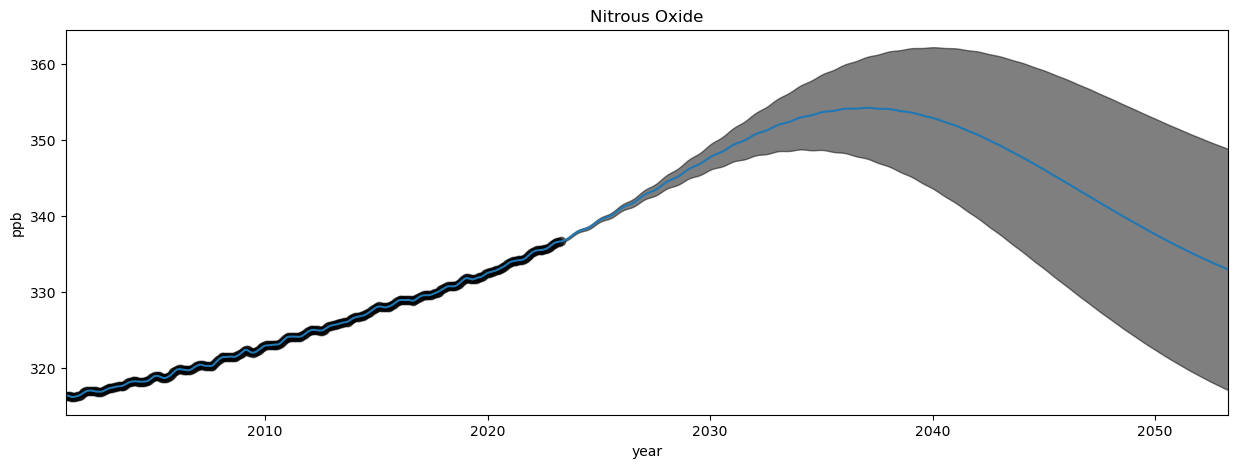

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.scatter(X, y, c='k', alpha=0.55)
plt.plot(X_, y_pred)
plt.fill_between(X_[:,0], y_pred-y_std, y_pred+y_std, alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.xlabel("year")
plt.ylabel("ppb")
plt.title("Nitrous Oxide")
plt.show()

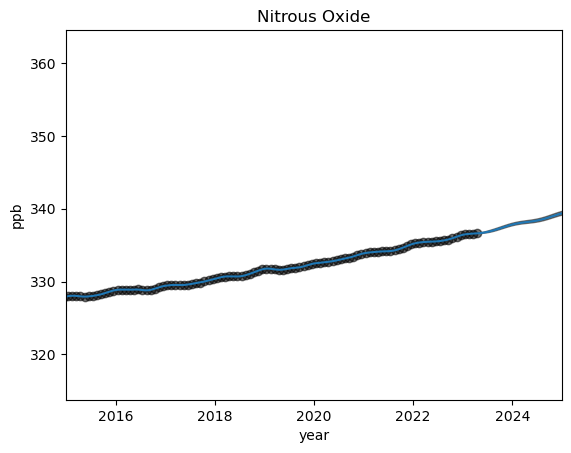

In [ ]:
plt.scatter(X, y, c='k', alpha=0.55)
plt.plot(X_, y_pred)
plt.fill_between(X_[:,0], y_pred-y_std, y_pred+y_std, alpha=0.5, color='k')
plt.xlim(2015, 2025)
plt.xlabel("year")
plt.ylabel("ppb")
plt.title("Nitrous Oxide")
plt.show()